 # Diplomatura en Ciencas de Datos, Aprendizaje Automático y sus Aplicaciones

 Autores: Matias Oria, Antonela Sambuceti, Pamela Pairo, Benjamín Ocampo

 Inicilamente definiremos algunas funciones, constantes y nombres de variables
 que utilizaremos durante nuestro análisis.

In [1]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import numpy as np

URL = "https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv"
DB = pd.read_csv(URL)

MINWAGE_IN_ARG = 18600

profile_years_experience = "profile_years_experience"
salary_in_usd = "salary_in_usd"
salary_monthly_NETO = "salary_monthly_NETO"
salary_monthly_BRUTO = "salary_monthly_BRUTO"
work_contract_type = "work_contract_type"
salary_in_usd = "salary_in_usd"
work_province = "work_province"
profile_age = "profile_age"
profile_gender = "profile_gender"

def clean_outliers(dataset, column_name):
    """Returns dataset removing the outlier rows from column @column_name."""
    interesting_col = dataset[column_name]
    # Here we can remove the outliers from both ends, or even add more restrictions.
    mask_outlier = (
        np.abs(interesting_col - interesting_col.mean()) <= (2.5 * interesting_col.std()))
    return dataset[mask_outlier]


def to_categorical(column, bin_size=10, min_cut=0, max_cut=50):
    if min_cut is None:
        min_cut = int(round(column.min())) - 1
    value_max = int(np.ceil(column.max()))
    max_cut = min(max_cut, value_max)
    intervals = [(x, x + bin_size) for x in range(min_cut, max_cut, bin_size)]
    if max_cut != value_max:
        intervals.append((max_cut, value_max))
    print(intervals)
    return pd.cut(column, pd.IntervalIndex.from_tuples(intervals))


 ## Asociación
 Para ver si existe una correlación entre el salario bruto y el neto analizamos
 el coeficiente de correlación de Pearson $\rho$ entre estas variables aleatorias.

In [2]:
df = DB.copy()

salary_cols = [salary_monthly_NETO, salary_monthly_BRUTO]
df[salary_cols].corr()


,salary_monthly_NETO,salary_monthly_BRUTO
salary_monthly_NETO,1.000000,0.833335
salary_monthly_BRUTO,0.833335,1.000000


 Notar que el valor de $\rho$ entre los salarios nos dá un valor positivo
 cercano a 1. Esto nos indica que existe una correlación entre las variables
 que se comporta aproximadamente lineal pero que aún así podría aún haber una
 fuerte relación no lineal entre ellas. También podemos visualizar la
 distribución conjunta de estas variables por medio un `scatterplot`.

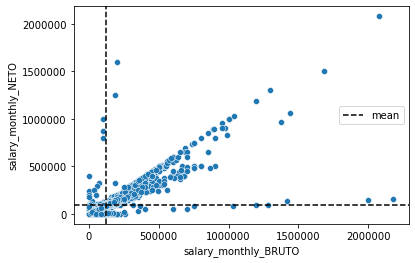

In [3]:
seaborn.scatterplot(
    data=df[salary_cols],
    x=salary_monthly_BRUTO, y=salary_monthly_NETO
)
plt.axvline(df[salary_monthly_BRUTO].mean(), color="black", linestyle="--", label="mean")
plt.axhline(df[salary_monthly_NETO].mean(), color="black", linestyle="--")
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
plt.legend()


 Claramente concuerda con el valor del $\rho$, sin embargo también deja en
 evidencia que un valor cerca de 1 no necesariamente implica que al incrementar
 el valor de una variable causa que la otra incremente. Observamos que una gran
 cantidad de sueldos en bruto están asociados con otra numerosa cantidad de
 sueldos en neto, debido a ello, podríamos prescindir del salario bruto.

 ## Densidad Conjunta
 El análisis de la Densidad Conjunta, en un primer momento nos permite detectar
 si existe algún patrón o compartamiento determinado entre dos variables, es
 decir si una variable se ve afectada ante un cambio en la otra. Si vemos que
 existe una cierta dependencia entre ellas, podemos incluso modelar una función
 de densidad o probalidad conjunta.

 Para variables numericas es util calcular medidas como la Covarianza o el
 Coeficiente de Correlación Lineal de Pearson, y tambien usar gráficos como por
 ejemplo de dispersión o de lineas. En cambio para variables categóricas es más
 frecuente usar como visualizaciones las tablas de frecuencias relativas o
 gráficos de barras. Cuando analizamos una variable categorica y una numerica
 son comunes los gráficos de barra o gráficos de caja.

 ## Elección de las Variables
 Categóricas: `work_province`, `work_contract_type`

 Numéricas: `salary_monthly_NETO`, `profile_years_experience`, `profile_age`


In [4]:
rvs = [
    work_province,
    work_contract_type,
    salary_monthly_NETO,
    profile_years_experience,
    profile_age
]

df = DB[
    (DB[profile_years_experience] < 50) &
    (DB[profile_age] < 100) &
    (DB[salary_monthly_NETO] > MINWAGE_IN_ARG)
][rvs]

df = clean_outliers(df, salary_monthly_NETO)
df.describe().round(2)

,salary_monthly_NETO,profile_years_experience,profile_age
count,5492.00,5492.00,5492.00
mean,87459.55,8.84,32.55
std,48795.27,7.03,7.26
min,18665.00,0.00,18.00
25%,54000.00,3.00,27.00
50%,79000.00,7.00,31.00
75%,105000.00,13.00,37.00
max,340099.00,44.00,67.00


 ## Análisis de Años de Experiencia y Salario Neto

In [5]:
df[[salary_monthly_NETO, profile_years_experience]].corr()

,salary_monthly_NETO,profile_years_experience
salary_monthly_NETO,1.000000,0.347364
profile_years_experience,0.347364,1.000000


 Se observa que $\rho$ entre los años de experiencia y el salario neto es
 positivo pero próximo a 0. Lo cual significa que no tienen una relación lineal
 fuerte como se observa en el siguiente gráfico de dispersión.

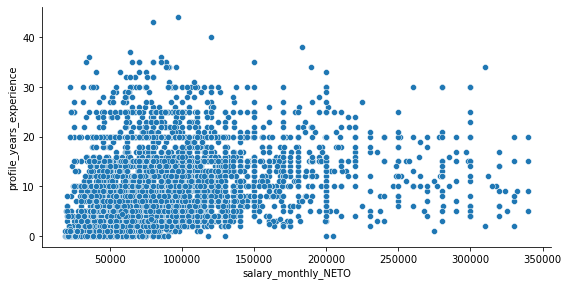

In [6]:
seaborn.pairplot(
    data=df,
    y_vars=[profile_years_experience],
    x_vars=[salary_monthly_NETO],
    height=4,aspect=2
)
plt.ticklabel_format(style='plain', axis='x')

 Observamos que la variable años de experiencia es discreta, por lo cual
 optamos por generar rangos para poder interpretar mejor la relación de estas
 variables.

In [7]:
profile_years_segment = 'profile_years_segment'

df[profile_years_segment] = to_categorical(
    df[profile_years_experience],
    min_cut=0,
    max_cut=30,
    bin_size=10
)

[(0, 10), (10, 20), (20, 30), (30, 44)]


 Con el siguiente gráfico podemos visualizar mejor la relación entre años de
 experiencia y salario mensual neto. Podemos observar que los salarios netos en
 promedio rondan en los \$115000 para el rango de 10 a 30 años de experiencia.
 Sin embargo, para el rango comprendido entre 0 y 10 años de experiencia y entre
 30 y 44 años de experiencia el salario promedio es menor.

 Notar que para los primeros 10 años de experiencia el intervalo de confianza
 es mucho más chico debido a que su estimación está dada por una muestra más
 representativa que para los intervalos (10, 20], (20, 30] y (30, 44]. Siendo
 este último el menos confiable. Ahora bien, es claro ver que el salario neto
 medio aumenta a partir de los primeros 10 años de experiencia. Esto lo
 confirma el siguiente cuadro de medidas descriptivas

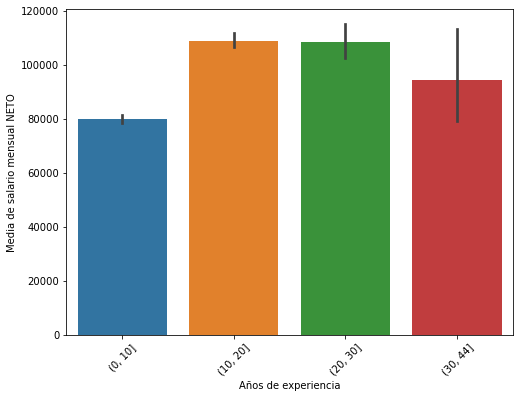

In [8]:

fig = plt.figure(figsize=(8,6))
seaborn.barplot(
    data=df,
    estimator=np.mean,
    x=profile_years_segment,
    y=salary_monthly_NETO
)
plt.xticks(rotation=45)
plt.ylabel("Media de salario mensual NETO")
plt.xlabel("Años de experiencia")
plt.ticklabel_format(style='plain', axis='y')

In [9]:
df[[profile_years_segment, salary_monthly_NETO]] \
    .groupby(profile_years_segment) \
    .describe() \
    .sort_values(by=profile_years_segment, ascending=True)


salary_monthly_NETO                               \
                                    count           mean           std   
profile_years_segment                                                    
(0, 10]                            3396.0   79889.852132  42755.992864   
(10, 20]                           1477.0  108888.046831  52987.798108   
(20, 30]                            300.0  108480.423400  56246.597014   
(30, 44]                             36.0   94435.722222  53081.424128   

                                                                        
                           min      25%        50%       75%       max  
profile_years_segment                                                   
(0, 10]                18729.0  52000.0   72243.03   95000.0  340000.0  
(10, 20]               22000.0  75000.0  100000.00  130000.0  340099.0  
(20, 30]               22000.0  70000.0   95000.00  130000.0  300000.0  
(30, 44]               33000.0  69250.0   80000.00   92125.0  310000.0

 ## Análisis Provincias de Argentina y Salario Neto
 Para una mejor visualización de este análisis decidimos agrupar las provincias
 por regiones y de esta forma obtener grupos más representativos.

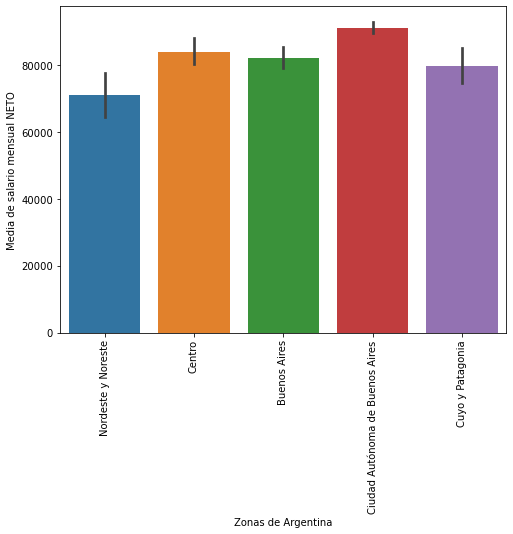

In [10]:
new_groups = {'Jujuy':'Nordeste y Noreste',
'Salta':'Nordeste y Noreste',
'Tucumán':'Nordeste y Noreste',
'Catamarca':'Nordeste y Noreste',
'Santiago del Estero':'Nordeste y Noreste',
'La Rioja':'Nordeste y Noreste',
'Corrientes':'Nordeste y Noreste',
'Entre Ríos':'Nordeste y Noreste',
'Chaco':'Nordeste y Noreste',
'Misiones':'Nordeste y Noreste',
'Formosa':'Nordeste y Noreste',
'GBA':'Buenos Aires',
'Provincia de Buenos Aires':'Buenos Aires',
'Córdoba':'Centro',
'Santa Fe':'Centro',
'La Pampa':'Centro',
'Santiago del Estero':'Centro',
'San Luis':'Cuyo y Patagonia',
'Mendoza':'Cuyo y Patagonia',
'San Juan':'Cuyo y Patagonia',
'Tierra del Fuego':'Cuyo y Patagonia',
'Santa Cruz':'Cuyo y Patagonia',
'Río Negro':'Cuyo y Patagonia',
'Chubut':'Cuyo y Patagonia',
'Neuquén':'Cuyo y Patagonia'}
order = ['Nordeste y Noreste', 'Centro', 'Buenos Aires','Ciudad Autónoma de Buenos Aires', 'Cuyo y Patagonia']

region = "region"

df[region] = df[work_province].replace(new_groups)
fig = plt.figure(figsize=(8,6))
seaborn.barplot(
    y=df[salary_monthly_NETO],
    x=df[region],
    estimator=np.mean, 
    order=order
)
plt.xticks(rotation=90)
plt.ylabel("Media de salario mensual NETO")
plt.xlabel("Zonas de Argentina")
plt.ticklabel_format(style='plain', axis='y')

In [11]:
df[[region, salary_monthly_NETO]].groupby(region).describe()

salary_monthly_NETO                \
                                              count          mean   
region                                                              
Buenos Aires                                  887.0  82038.487317   
Centro                                        739.0  83832.556942   
Ciudad Autónoma de Buenos Aires              3441.0  91141.645513   
Cuyo y Patagonia                              216.0  79525.211250   
Nordeste y Noreste                            209.0  70868.856268   

                                                                          \
                                          std      min      25%      50%   
region                                                                     
Buenos Aires                     48571.844877  19000.0  50000.0  71033.0   
Centro                           51132.326743  20000.0  52601.5  72000.0   
Ciudad Autónoma de Buenos Aires  48409.788706  18665.0  58000.0  83000.0   
Cuyo y Patagonia                 39008.399265  19000.0  51925.0  73077.5   
Nordeste y Noreste               49603.291887  18729.0  40000.0  58000.0   

                                                     
                                      75%       max  
region                                               
Buenos Aires                      99550.0  340000.0  
Centro                            99000.0  340000.0  
Ciudad Autónoma de Buenos Aires  110000.0  340099.0  
Cuyo y Patagonia                 100000.0  252000.0  
Nordeste y Noreste                80000.0  300000.0

 Conluimos que las regiones de Buenos Aires y Centro, son las mejores pagas,
 siendo Noreste y Nordeste las que tienen el menor salario neto promedio.

 ## Años de Edad - Tipos de Contrato

No handles with labels found to put in legend.
[(15, 20), (20, 25), (25, 30), (30, 35), (35, 40), (40, 45), (45, 50), (50, 67)]


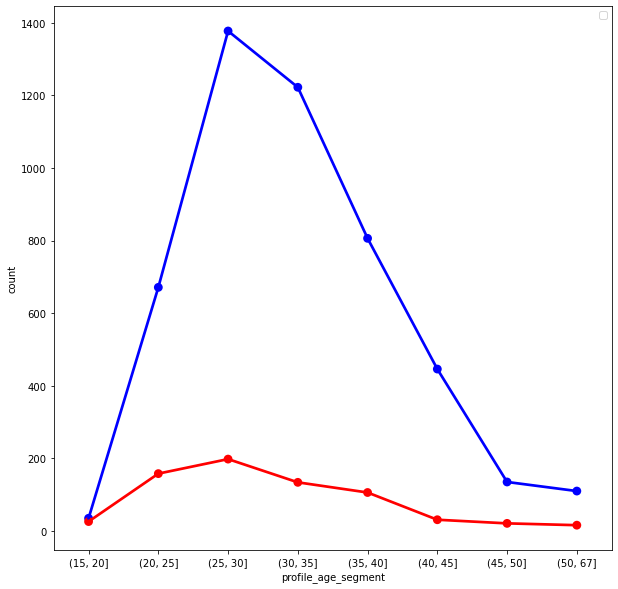

In [12]:

profile_age_segment = "profile_age_segment"

df[profile_age_segment] = to_categorical(
    df[profile_age],
    bin_size=5,
    min_cut=15,
    max_cut=50
)

fig = plt.figure(figsize=(10,10))
df_ages_fulltime = df[df[work_contract_type] == "Full-Time"] \
    .groupby(profile_age_segment).size() \
    .to_frame().rename(columns={0: "count"}) \
    .reset_index()
df_ages_nofulltime = df[df[work_contract_type] != "Full-Time"] \
    .groupby(profile_age_segment).size() \
    .to_frame().rename(columns={0: "count"}) \
    .reset_index()

seaborn.pointplot(
    data=df_ages_fulltime,
    x=profile_age_segment, y="count",
    color='b',
    legend='fulltime'
)

seaborn.pointplot(
    data=df_ages_nofulltime,
    x=profile_age_segment, y="count",
    color='r',
    legend='nofulltime'
)
plt.legend()
plt.show()


 Concluimos que la edad sí tiene una influencia en la elección del tipo de
 contrato. Notar


 ## Tipos de Contraros Y Salarios Netos Medios

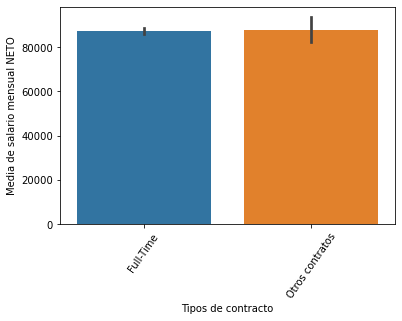

In [13]:
new_groups = {
    'Part-Time':'Otros contratos',
    'Tercerizado (trabajo a través de consultora o agencia)':'Otros contratos',
    'Remoto (empresa de otro país)':'Otros contratos',
    'Freelance':'Otros contratos'}
grouped_contract = df[work_contract_type].replace(new_groups)
seaborn.barplot(y=df[salary_monthly_NETO], x=grouped_contract, estimator=np.mean)
plt.xticks(rotation=55)
plt.ylabel("Media de salario mensual NETO")
plt.xlabel("Tipos de contracto")
plt.ticklabel_format(style='plain', axis='y')


 Observamos que la media de los otros contratos es considerablemente superior
 que los Full - Time. Veamos especificamente en que tipo de contrato se
 encuentran estos mayores sueldos.

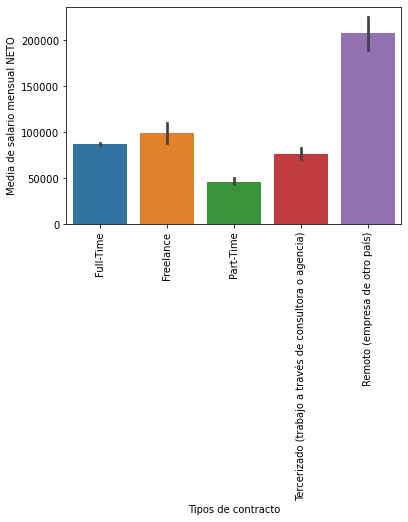

In [14]:
seaborn.barplot(
    y=df[salary_monthly_NETO],
    x=df[work_contract_type],
    estimator=np.mean
)
plt.xticks(rotation=90)
plt.ylabel("Media de salario mensual NETO")
plt.xlabel("Tipos de contracto")
plt.ticklabel_format(style='plain', axis='y')


 Los mayores sueldos se encuentran en las personas que trabajan de forma Remota
 para otro país, es decir los sueldos dolarizados.

In [15]:
df[[work_contract_type, salary_monthly_NETO]] \
    .groupby(work_contract_type) \
    .describe()


salary_monthly_NETO  \
                                                                 count   
work_contract_type                                                       
Freelance                                                        131.0   
Full-Time                                                       4802.0   
Part-Time                                                        267.0   
Remoto (empresa de otro país)                                     98.0   
Tercerizado (trabajo a través de consultora o a...               194.0   

                                                                   \
                                                             mean   
work_contract_type                                                  
Freelance                                            99149.580153   
Full-Time                                            87401.668407   
Part-Time                                            46471.213820   
Remoto (empresa de otro país)                       207846.247449   
Tercerizado (trabajo a través de consultora o a...   76596.307216   

                                                                           \
                                                             std      min   
work_contract_type                                                          
Freelance                                           66745.904887  20000.0   
Full-Time                                           44002.910939  19650.0   
Part-Time                                           26921.728750  18665.0   
Remoto (empresa de otro país)                       88465.876261  20000.0   
Tercerizado (trabajo a través de consultora o a...  41799.500015  21000.0   

                                                                        \
                                                         25%       50%   
work_contract_type                                                       
Freelance                                            47500.0   80000.0   
Full-Time                                            57000.0   80000.0   
Part-Time                                            30000.0   42000.0   
Remoto (empresa de otro país)                       136750.0  203750.0   
Tercerizado (trabajo a través de consultora o a...   48000.0   69000.0   

                                                                        
                                                         75%       max  
work_contract_type                                                      
Freelance                                           145000.0  280000.0  
Full-Time                                           105000.0  340099.0  
Part-Time                                            55000.0  310000.0  
Remoto (empresa de otro país)                       288750.0  340000.0  
Tercerizado (trabajo a través de consultora o a...   92750.0  330000.0

 ## Densidad condicional
 Estudie la distribución del salario según el nivel de estudio.
 Separe la población según el nivel de estudio (elija dos subpoblaciones
 numerosas) y grafique de manera comparativa ambos histogramas de la variable
 'salary_monthly_NETO' ¿Considera que ambas variables son independientes? ¿Qué
 analizaría al respecto?
 Calcule medidas de centralización y dispersión para cada subpoblación

 ## Distribución del salario neto y nivel de estudio

,Study Level,Frecuency
0,Universitario,3731
1,Terciario,1036
2,Secundario,403
3,Posgrado,297
4,Doctorado,24
5,Primario,2
6,Posdoctorado,2


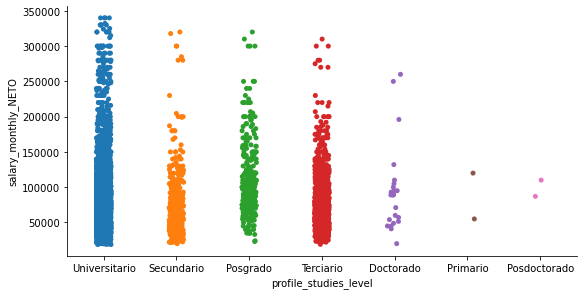

In [16]:
df = DB[(DB[salary_monthly_NETO] > MINWAGE_IN_ARG)]
df = clean_outliers(df, salary_monthly_NETO)

seaborn.catplot(data=df, y='salary_monthly_NETO',
                x='profile_studies_level', height=4, aspect=2)

Study_count = df.profile_studies_level.value_counts()\
    .reset_index()\
    .rename(columns={'index': 'Study Level', 'profile_studies_level':'Frecuency'})
Study_count[:10]

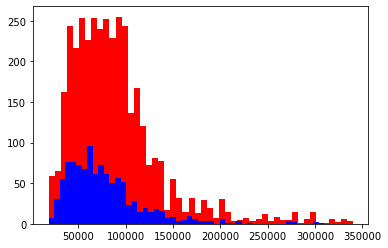

In [17]:
salary_col= 'salary_monthly_NETO'
df_U = df[df['profile_studies_level'] == 'Universitario']
df_T =df[df['profile_studies_level'] == 'Terciario']

plt.hist(df_U[salary_col], color='red', bins=50)
plt.hist(df_T[salary_col], color='blue', bins=50)
plt.show()

 La probabilidad de estar por arriba del promedio sin importar el grado de
 estudio 33,13%, mientras que la probabilidad de estar por arriba del promedio
 teniendo un nivel de estudio terciario es de el 23,88 %

In [18]:
avg_salary = df[salary_monthly_NETO].mean()

p_above_avg = len(df[df[salary_col] >= avg_salary]) / len(df)

is_above_avg = len(df[df[salary_col] > avg_salary])#Cantidad A
Terciario= len(df[df["profile_studies_level"] == "Terciario"]) #Cantidad B
Total=len(df) #Cantidad Total
condicion= (df[salary_col] > avg_salary) & (df["profile_studies_level"] == "Terciario")
Prob_AB=len(df[condicion])/Terciario

is_above_avg2 = len(df[df[salary_col] > avg_salary])#Cantidad A
Universitario = len(df[df["profile_studies_level"] == "Universitario"]) #Cantidad B
Total2=len(df) #Cantidad Total
condicion2= (df[salary_col] > avg_salary) & (df["profile_studies_level"] == "Universitario")
Prob_AB2=len(df[condicion2])/Universitario
Prob_AB2

print(
    f"La probabilidad de estar por arriba del promedio sin importar el grado de estudio es {p_above_avg * 100:.2f}%"
)
print(
    f"mientras que la probabilidad de estar por arriba del promedio \
    teniendo un nivel de estudio terciario es de el {Prob_AB * 100:.2f}%"
)
print(
    f"Teniendo estudios universitarios es {Prob_AB2 * 100:.2f}%"
)


La probabilidad de estar por arriba del promedio sin importar el grado de estudio es 40.58%
mientras que la probabilidad de estar por arriba del promedio     teniendo un nivel de estudio terciario es de el 30.60%
Teniendo estudios universitarios es 42.43%


In [19]:

Prob_A= is_above_avg/Total
Prob_B= Terciario/Total

(round(Prob_A * Prob_B, 4), round(Prob_AB, 4))

(0.0765, 0.306)

In [20]:
(round(Prob_AB, 4), round(Prob_A, 4))


(0.306, 0.4058)

 Densidad Conjunto Condicional

In [21]:
rvs = [
    work_province,
    work_contract_type,
    salary_monthly_NETO,
    profile_years_experience,
    profile_gender
]

df = DB[
    (DB[profile_years_experience] < 50) &
    (DB[profile_age] < 100) &
    (DB[salary_monthly_NETO] > MINWAGE_IN_ARG) &
    (DB.salary_in_usd != "Mi sueldo está dolarizado")
][rvs]

df = clean_outliers(df, salary_monthly_NETO)
df.describe().round(2)


,salary_monthly_NETO,profile_years_experience
count,4949.00,4949.00
mean,79865.61,8.76
std,36234.28,7.06
min,18665.00,0.00
25%,52500.00,3.00
50%,75000.00,7.00
75%,100000.00,13.00
max,225000.00,44.00


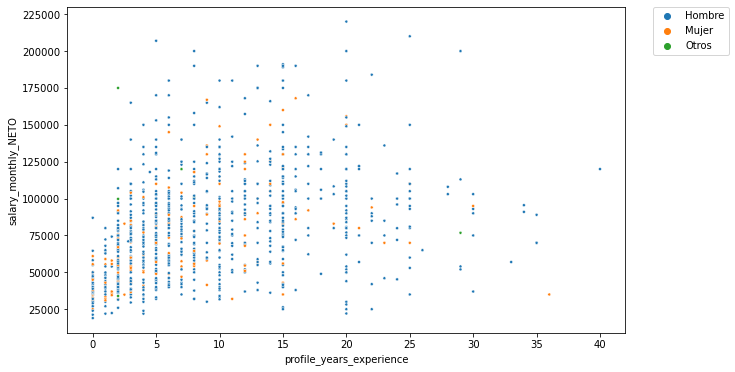

In [22]:

plt.figure(figsize=(10,6))
seaborn.scatterplot(data=df.sample(1000), 
    x=profile_years_experience, y=salary_monthly_NETO,
    marker='.',
    hue=profile_gender
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)